In [ ]:
DATA_PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
NAMES = ['sepal length', 'sepal width', 'petal length', 'petal width', 'target']

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **1. PCA**

In [ ]:
def PCA(X, num_components):  
    
    # Step 1
    X_centered = X - np.mean(X, axis = 0)
    
    # Step 2 
    covariance_matrix = np.cov(X_centered, rowvar = False)
    
    # Step 3
    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)
    
    # Step 4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues  = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
    
    # Step 5
    eigenvectors_subset = sorted_eigenvectors[:, 0:num_components]
    
    # Step 6
    X_reduced = np.dot(eigenvectors_subset.T, X_centered.T).T
    
    return X_reduced, sorted_eigenvalues, sorted_eigenvectors
    

In [ ]:
# Read dataset
df = pd.read_csv(DATA_PATH, names=NAMES)

# Split the data into X and y
X = df.iloc[:, 0:4]
y = df.iloc[:, 4]

# Applying PCA function to X
mat_reduced, sorted_eigenvalues, sorted_eigenvectors = PCA(X, 2)

# Creating DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced, columns = ["PC1", "PC2"])

# Concat it with target variable
principal_df = pd.concat([principal_df, pd.DataFrame(y)], axis = 1)


In [ ]:
# Display data sample
principal_df.head(2)

,PC1,PC2,target
0,2.684207,0.326607,Iris-setosa
1,2.715391,-0.169557,Iris-setosa


In [ ]:
# Sorted eigenvectors
print(sorted_eigenvectors)

[[-0.36158968  0.65653988  0.58099728  0.31725455]
 [ 0.08226889  0.72971237 -0.59641809 -0.32409435]
 [-0.85657211 -0.1757674  -0.07252408 -0.47971899]
 [-0.35884393 -0.07470647 -0.54906091  0.75112056]]


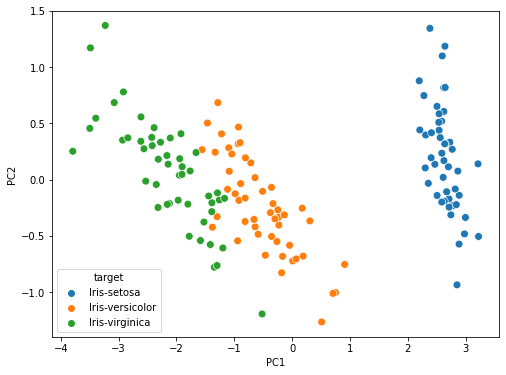

In [ ]:
# Plot data after applying PCA
plt.figure(figsize = (8,6))
sns.scatterplot(data = principal_df, x = 'PC1',
                y = 'PC2' ,hue = 'target', s = 60 )

In [ ]:
# Sorted eigenvalues
print(sorted_eigenvalues)

[4.22484077 0.24224357 0.07852391 0.02368303]


In [ ]:
# Explained variance
var_exp = [(i/sum(sorted_eigenvalues))*100
                            for i in sorted_eigenvalues]
print(var_exp)

# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[92.46162071742687, 5.301556785053501, 1.7185139525006734, 0.5183085450189561]
[ 92.46162072  97.7631775   99.48169145 100.        ]


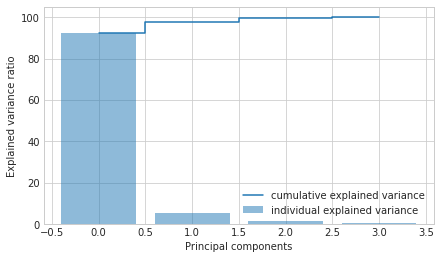

In [ ]:
with plt.style.context("seaborn-whitegrid"):
    plt.figure(figsize=(7,4))

    plt.bar(range(4), var_exp, alpha = 0.5,
            label = "individual explained variance")
    plt.step(range(4), cum_var_exp, where = "mid",
             label = "cumulative explained variance")

    plt.ylabel("Explained variance ratio")
    plt.xlabel("Principal components")
    plt.legend(loc = "best")


______

#### Using sklearn

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization
pca = PCA()
# Set tolerance to a large number to make it faster
logistic = LogisticRegression(max_iter = 1000, tol = 0.1)
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

# Parameters of pipeline
param_grid = {
    "pca__n_components": [1, 2 , 3, 4],
    "logistic__C": np.logspace(-4, 4, 4)
    }
search = GridSearchCV(pipe, param_grid, n_jobs = -1)
search.fit(X, y)

# Best parameter
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.987):
{'logistic__C': 21.54434690031882, 'pca__n_components': 3}


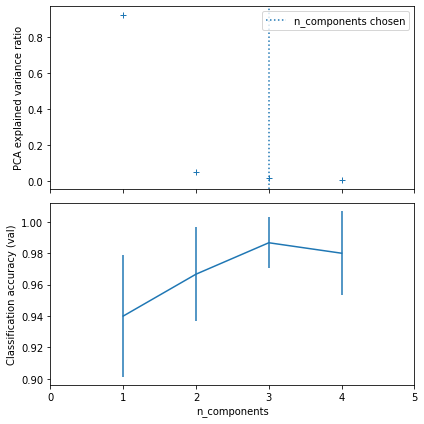

In [ ]:
# Plot PCA spectrum
pca.fit(X)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=4)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=10))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(0,5)
plt.tight_layout()
plt.show()

===========================================================================


In [ ]:
# Import Dataset
from sklearn import datasets
data = datasets.load_iris()
X, y = data.data, data.target

# **2. LDA**

In [ ]:
class LDA:
    def __init__(self, num_components):
        self.num_components = num_components
        self.linear_discriminants = None
        self.mean_overall = None
        self.num_classes = None
    
    def fit(self, X, y):
        num_features = X.shape[1]        
        SW = np.zeros((num_features, num_features)) # (n,n)
        SB = np.zeros((num_features, num_features)) # (n,n)
        
        self.mean_overall = np.mean(X, axis = 0) 
        class_labels = np.unique(y)
        self.num_classes = len(class_labels)
        for c in class_labels:
            X_c = X[y == c] 
            mean_c = np.mean(X_c, axis = 0)
            
            # Within class scatter matrix 
            # SW = sum((X_c - mean_X_c)^2)
            SW += (X_c - mean_c).T.dot(X_c - mean_c)

            # Between class scatter matrix
            # SB = sum(n_c * (mean_c - mean_overall)^2)
            n_c = X_c.shape[0]
            mean_diff = (mean_c - self.mean_overall).reshape(num_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^(-1) * SB -> Objective function
        obj_fn = np.linalg.inv(SW).dot(SB)
        # Get eigen_values and eigen_vectors of the obj_fn
        eigen_values, eigen_vectors = np.linalg.eig(obj_fn)
        
        # eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigen_vectors = eigen_vectors.T
        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvalues  = eigen_values[sorted_index]
        sorted_eigenvectors = eigen_vectors[:, sorted_index]

        # store first n eigen_vectors
        self.linear_discriminants = sorted_eigenvectors[0: self.num_components]

    def transform(self, X):
        # project the data on the new selected basis
        return np.dot(X, self.linear_discriminants.T)
    
    # def predict(self, X):
    #     # y(x) = W.T * X + W0 ---> Linear 
    #     W0 = np.zeros((self.num_classes))
    #     total = 0
    #     for c in self.mean_overall:
    #         total += np.dot(self.linear_discriminants, c)
    #         W0 = - 0.5 * total 

    #     y = np.zeros((len(X), self.num_classes))
    #     predict = np.zeros((len(X)), dtype=int)
    #     for i in range(len(X)):
    #         for j in range(self.num_classes):
    #             y[i,j] = np.dot(self.linear_discriminants[j].T, X[i]) + W0[j]
    #         predict[i] = np.argmin(y[i])
    #     return predict
        
    

In [ ]:
# Applying LDA function to X and y
lda = LDA(2)
lda.fit(X, y)
X_projected = lda.transform(X)
# y_predict = lda.predict(X)

In [ ]:
# Shapes
print("Shape of X:", X.shape)
print("Shape of transformed X:", X_projected.shape)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


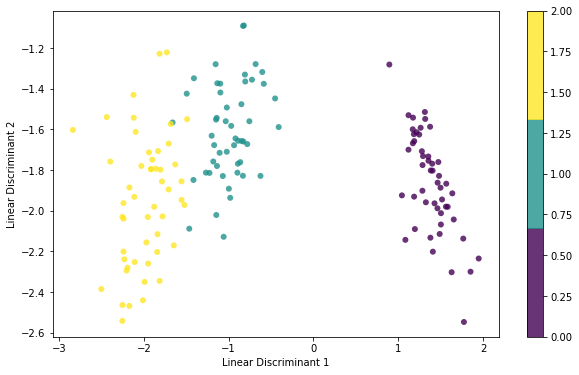

In [ ]:
x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

# Plot data after applying LDA
plt.figure(figsize = (10,6))
plt.scatter(x1, x2, c = y, edgecolor = "none",
            alpha = 0.8, cmap = plt.cm.get_cmap("viridis", 3))
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar()
plt.show()

_________

#### Using sklearn

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 2)
lda.fit(X, y)
X_projected = lda.transform(X)

In [ ]:
# Shapes
print("Shape of X:", X.shape)
print("Shape of transformed X:", X_projected.shape)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


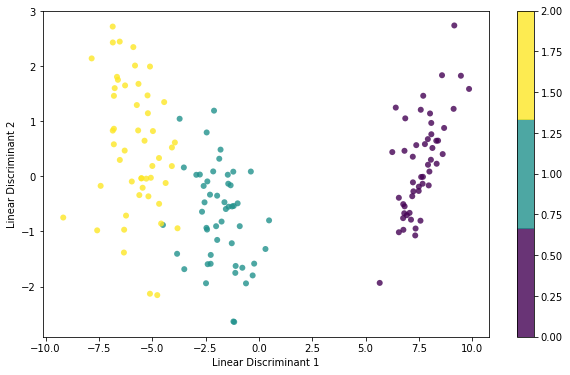

In [ ]:
x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

# Plot data after applying LDA
plt.figure(figsize = (10,6))
plt.scatter(x1, x2, c = y, edgecolor = "none",
            alpha = 0.8, cmap = plt.cm.get_cmap("viridis", 3))
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar()
plt.show()

================================================================================

# **3. NMF** 

In [ ]:
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])

from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
np.dot(W,H)

array([[1.00063558, 0.99936347],
       [1.99965977, 1.00034074],
       [2.99965485, 1.20034566],
       [3.9998681 , 1.0001321 ],
       [5.00009002, 0.79990984],
       [6.00008587, 0.999914  ]])